# COSC 411: Artificial Intelligence

Instructor: Dr. Shuangquan (Peter) Wang

Email: spwang@salisbury.edu

Department of Computer Science, Salisbury University


# Module 3_ML algorithms and application

## 6. Clustering


**Contents of this note refer to 1) Python Data Science Handbook (https://cocalc.com/share/public_paths/8b892baf91f98d0cf6172b872c8ad6694d0f7204/notebooks%2F05.11-K-Means.ipynb); 2) Dr.Robert Michael Lewis's teaching materials at Department of Computer Science, William & Mary; 3) book "Python Machine Learning"; 4) textbook "Data Science from Scratch"; 5) Python toturial: https://docs.python.org/3/tutorial/**

**<font color=red>All rights reserved. Dissemination or sale of any part of this note is NOT permitted.</font>**

**Note: The contents of this note are mainly from https://cocalc.com/share/public_paths/8b892baf91f98d0cf6172b872c8ad6694d0f7204/notebooks%2F05.11-K-Means.ipynb**

# k-Means

The *k*-means algorithm searches for a pre-determined number of clusters within an **unlabeled** multidimensional dataset.
It accomplishes this using a simple conception of what the optimal clustering looks like:

- The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
- Each point is closer to its own cluster center than to other cluster centers.

Those two assumptions are the basis of the *k*-means model.
We will soon dive into exactly *how* the algorithm reaches this solution, but for now let's take a look at a simple dataset and see the *k*-means result.

First, let's generate a two-dimensional dataset containing four distinct blobs.
To emphasize that this is an unsupervised algorithm, we will leave the labels out of the visualization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import numpy as np

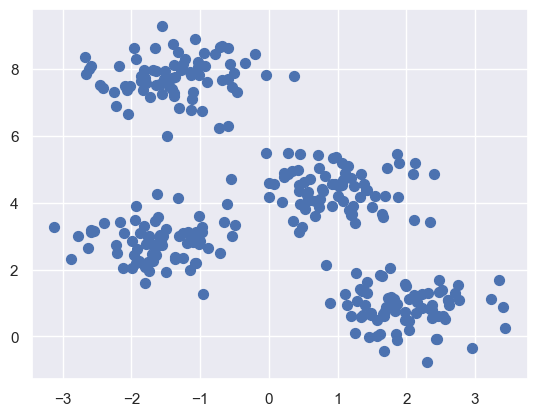

In [2]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

It is relatively easy to pick out the four clusters.
The *k*-means algorithm does this automatically, and in Scikit-Learn uses the typical estimator API:

In [3]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

C:\Users\CSAdmin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Let's visualize the results by plotting the data colored by these labels.
We will also plot the cluster centers as determined by the *k*-means estimator:

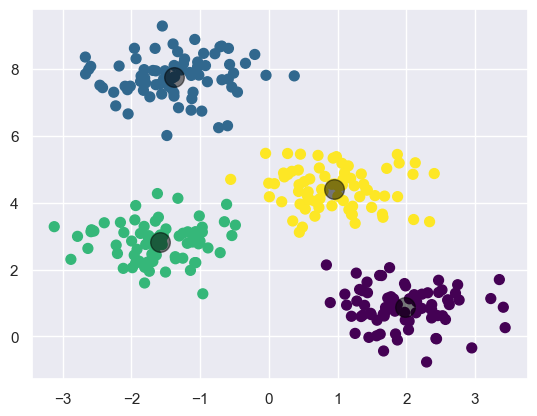

In [4]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

The good news is that the *k*-means algorithm (at least in this simple case) assigns the points to clusters very similarly to how we might assign them by eye.
But you might wonder how this algorithm finds these clusters so quickly! After all, the number of possible combinations of cluster assignments is exponential in the number of data points—an exhaustive search would be very, very costly.
Fortunately for us, such an exhaustive search is not necessary: instead, the typical approach to *k*-means involves an intuitive iterative approach known as *expectation–maximization*.

## k-Means Algorithm: Expectation–Maximization

Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science.
*k*-means is a particularly simple and easy-to-understand application of the algorithm.
In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged
   1. *E-Step*: assign points to the nearest cluster center
   2. *M-Step*: set the cluster centers to the mean 

Here the "E-step" or "Expectation step" is so-named because it involves updating our expectation of which cluster each point belongs to.
The "M-step" or "Maximization step" is so-named because it involves maximizing some fitness function that defines the location of the cluster centers—in this case, that maximization is accomplished by taking a simple mean of the data in each cluster.

The literature about this algorithm is vast, but can be summarized as follows: under typical circumstances, each repetition of the E-step and M-step will always result in a better estimate of the cluster characteristics.

We can visualize the algorithm as shown in the following figure.
For the particular initialization shown here, the clusters converge in just three iterations.


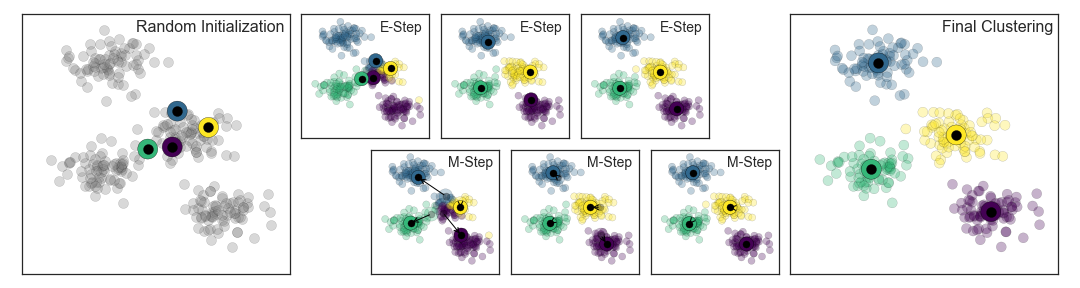

The *k*-Means algorithm is simple enough that we can write it in a few lines of code.
The following is a very basic implementation:

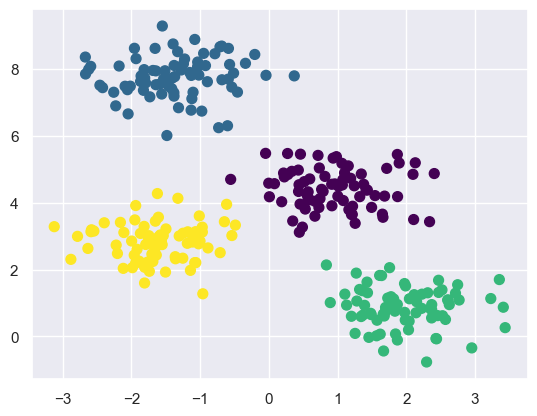

In [5]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### There are a few issues to be aware of when using the expectation–maximization algorithm.

#### The globally optimal result may not be achieved
First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the *global* best solution.
For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

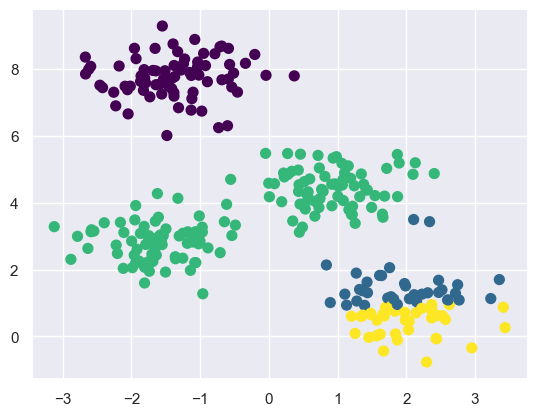

In [6]:
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Here the E–M approach has converged, but has not converged to a globally optimal configuration. 

**For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the ``n_init`` parameter, which defaults to 10).**

- https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

#### The number of clusters must be selected beforehand
Another common challenge with *k*-means is that you must tell it how many clusters you expect: it cannot learn the number of clusters from the data.
For example, if we ask the algorithm to identify six clusters, it will happily proceed and find the best six clusters:

In [ ]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

Alternatively, you might use a more complicated clustering algorithm which has a better quantitative measure of the fitness per number of clusters or which *can* choose a suitable number of clusters (e.g., DBSCAN available in the ``sklearn.cluster`` submodule: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html#sklearn.cluster.DBSCAN)

#### k-means is limited to linear cluster boundaries
The fundamental model assumptions of *k*-means (points will be closer to their own cluster center than to others) means that the algorithm will often be ineffective if the clusters have complicated geometries.

In particular, the boundaries between *k*-means clusters will always be linear, which means that it will fail for more complicated boundaries.
Consider the following data, along with the cluster labels found by the typical *k*-means approach:

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

In [ ]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

This situation also appears in Support Vector Machines, where a kernel transformation is used to project the data into a higher dimension where a linear separation is possible.
We might imagine using the same trick to allow *k*-means to discover non-linear boundaries.

One version of this kernelized *k*-means is implemented in Scikit-Learn within the ``SpectralClustering`` estimator.
It uses the graph of nearest neighbors to compute a higher-dimensional representation of the data, and then assigns labels using a *k*-means algorithm:

In [ ]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

We see that with this kernel transform approach, the kernelized *k*-means is able to find the more complicated nonlinear boundaries between clusters.

#### k-means can be slow for large numbers of samples
Because each iteration of *k*-means must access every point in the dataset, the algorithm can be relatively slow as the number of samples grows.

You might wonder if this requirement to use all data at each iteration can be relaxed; for example, you might just use a subset of the data to update the cluster centers at each step.
This is the idea behind batch-based *k*-means algorithms, one form of which is implemented in ``sklearn.cluster.MiniBatchKMeans``.
The interface for this is the same as for standard ``KMeans``; we will see an example of its use later.

## K-means Examples


### Example 1: k-means on digits

Let's take a look at applying *k*-means on the UCI ML hand-written digits dataset.

Here we will attempt to use *k*-means to try to identify similar digits *without using the original label information*; this might be similar to a first step in extracting meaning from a new dataset about which you don't have any *a priori* label information.


### UCI ML hand-written digits dataset

- https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html

The digits dataset consists of 1,797 samples with 64 features, where each of the 64 features is the brightness of one pixel in an 8×8 image. 

Each datapoint is a 8x8 image of a digit.
- Classes: 10
- Samples per class: ~180
- Samples total: 1797
- Dimensionality: 64
- Features: integers 0-16

We will start by loading the digits and then finding the ``KMeans`` clusters.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

In [ ]:
print(digits.data[1])

The clustering can be performed as:

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

The result is 10 clusters in 64 dimensions.
Notice that the cluster centers themselves are 64-dimensional points, and can themselves be interpreted as the "typical" digit within the cluster.
Let's see what these cluster centers look like:

In [ ]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

We see that *even without the labels*, ``KMeans`` is able to find clusters whose centers are recognizable digits, with perhaps the exception of 1 and 8.

Because *k*-means knows nothing about the identity of the cluster, the 0–9 labels may be permuted.
We can fix this by matching each learned cluster label with the true labels found in them:

In [ ]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
# digits.target are the original labels of these digit datapoints

Now we can check how accurate our unsupervised clustering was in finding similar digits within the data:

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

With just a simple *k*-means algorithm, we discovered the correct grouping for 80% of the input digits!
Let's check the confusion matrix for this:

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

As we might expect from the cluster centers we visualized before, the main point of confusion is between the eights and ones.
But this still shows that using *k*-means, we can essentially build a digit classifier *without reference to any known labels*!


# Hierarchical Clustering

Contents of this part are from "Python Machine Learning Jupyter Notebooks" by Dr. Tirthajyoti Sarkar (https://github.com/tirthajyoti/Machine-Learning-with-Python/tree/master)

Hierarchical clustering involves creating clusters that have a predetermined ordering from top to bottom. For example, all files and folders on the hard disk are organized in a hierarchy. There are two types of hierarchical clustering, Divisive and Agglomerative.

**Divisive method**

In this method we assign all of the observations to a single cluster and then partition the cluster to two least similar clusters. Finally, we proceed recursively on each cluster until there is one cluster for each observation.

**Agglomerative method**
		
In this method we assign each observation to its own cluster. Then, compute the similarity (e.g., distance) between each of the clusters and join the two most similar clusters. Finally, repeat steps 2 and 3 until there is only a single cluster left.

## Linkage or distance matrix

Before any clustering is performed, it is required to determine the proximity matrix containing the distance between each point using a distance function. Then, the matrix is updated to display the distance between each cluster. The following three methods differ in how the distance between each cluster is measured.

**Single Linkage** 		
In single linkage hierarchical clustering, the distance between two clusters is defined as the shortest distance between two points in each cluster. For example, the distance between clusters “r” and “s” is equal to the length of the arrow between their two closest points.
<img src=http://www.saedsayad.com/images/Clustering_single.png>

**Complete Linkage**		
In complete linkage hierarchical clustering, the distance between two clusters is defined as the longest distance between two points in each cluster. For example, the distance between clusters “r” and “s” is equal to the length of the arrow between their two furthest points.
<img src=http://www.saedsayad.com/images/Clustering_complete.png>

**Average Linkage**	
In average linkage hierarchical clustering, the distance between two clusters is defined as the average distance between each point in one cluster to every point in the other cluster. For example, the distance between clusters “r” and “s” is equal to the average length each arrow between connecting the points of one cluster to the other.
<img src=http://www.saedsayad.com/images/Clustering_average.png>



# Clustering with a shopping trend data set

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Read in the data set

In [ ]:
df = pd.read_csv('Mall_Customers.csv')
df.head(10)

In [ ]:
df.describe()

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Annual income distribution",fontsize=16)
plt.xlabel ("Annual income (k$)",fontsize=14)
plt.grid(True)
plt.hist(df['Annual Income (k$)'],color='orange',edgecolor='k')
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Spending Score distribution",fontsize=16)
plt.xlabel ("Spending Score (1-100)",fontsize=14)
plt.grid(True)
plt.hist(df['Spending Score (1-100)'],color='green',edgecolor='k')
plt.show()

### So, is there a definitive correlation between annual income and spending score? - *Apparently not*

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Annual Income and Spending Score correlation",fontsize=18)
plt.xlabel ("Annual Income (k$)",fontsize=14)
plt.ylabel ("Spending Score (1-100)",fontsize=14)
plt.grid(True)
plt.scatter(df['Annual Income (k$)'],df['Spending Score (1-100)'],color='red',edgecolor='k',alpha=0.6, s=100)
plt.show()

### How about correlation between age and spending score? 

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Age and Spending Score correlation",fontsize=18)
plt.xlabel ("Age",fontsize=14)
plt.ylabel ("Spending Score (1-100)",fontsize=14)
plt.grid(True)
plt.scatter(df['Age'],df['Spending Score (1-100)'],color='blue',edgecolor='k',alpha=0.6, s=100)
plt.show()

## Strategy
**Therefore, we will explore clustering the customers based on their annual income and spending score to see if there are distinguisbale clusters which the mall can target.**

We could use k-means but we don't have any idea about the number of hidden clusters. We will see that hierarchial clustering with dendograms will give us a good insight on the optimal number of clusters.

## Dendograms

In [ ]:
X = df.iloc[:,[3,4]].values

In [ ]:
import scipy.cluster.hierarchy as sch

plt.figure(figsize=(15,6))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
#plt.grid(True)

# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html
dendrogram = sch.dendrogram(sch.linkage(X, method = 'average'))
plt.show()

### Optimal number of clusters

Often, the optimal number of clusters can be found from a Dendogram is a simple manner.
* Look for the longest stretch of vertical line which is not crossed by any ***extended*** horizontal lines (here *extended* means horizontal lines i.e. the cluster dividers are extended infinitely to both directions).
* Now take any point on that stretch of line and draw an imaginary horizontal line.
* Count how many vertical lines this imaginary lines crossed.
* That is likely to be the optimal number of clusters.


### Agglomerative Clustering Example

### Build the model

In [ ]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage = 'average')
y_hc = hc.fit_predict(X)

### Plot the clusters and label customer types
* _Careful_ - high income but low spenders
* _Standard_ - middle income and middle spenders
* **_Target group_ - middle-to-high income and high spenders (should be targeted by the mall)**
* _Careless_ - low income but high spenders (should be avoided because of possible credit risk)
* _Sensible_ - low income and low spenders

In [ ]:
plt.figure(figsize=(12,7))
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Careful')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Standard')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Target group')
plt.scatter(X[y_hc == 3, 0], X[y_hc == 3, 1], s = 100, c = 'orange', label = 'Careless')
plt.scatter(X[y_hc == 4, 0], X[y_hc == 4, 1], s = 100, c = 'magenta', label = 'Sensible')
plt.title('Clustering of customers',fontsize=20)
plt.xlabel('Annual Income (k$)',fontsize=16)
plt.ylabel('Spending Score (1-100)',fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.axhspan(ymin=60,ymax=100,xmin=0.4,xmax=0.96,alpha=0.3,color='yellow')
plt.show()

## Verifying the optimal number of clusters by k-means algorithm

We run k-means++ model (k-means with carefully initialized centroids) iterating over number of clusters (1 to 15) and plot the ***within-cluster-sum-of-squares (WCSS) matric*** to determine the optimum number of cluster by elbow method

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
wcss = []
for i in range(1, 16):
    kmeans = KMeans(n_clusters = i, init = 'k-means++')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

with plt.style.context(('fivethirtyeight')):
    plt.figure(figsize=(10,6))
    plt.plot(range(1, 16), wcss)
    plt.title('The Elbow Method with k-means++\n',fontsize=25)
    plt.xlabel('Number of clusters')
    plt.xticks(fontsize=20)
    plt.ylabel('WCSS (within-cluster sums of squares)')
    plt.vlines(x=5,ymin=0,ymax=250000,linestyles='--')
    plt.text(x=5.5,y=110000,s='5 clusters seem optimal choice \nfrom the elbow position',
             fontsize=25,fontdict={'family':'Times New Roman'})
    plt.show()

# Density-based clustering


Contents of this part are from "Python Machine Learning Jupyter Notebooks" by Dr. Tirthajyoti Sarkar (https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/DBScan_Clustering.ipynb)

## DBSCAN Clustering
The DBSCAN algorithm views clusters as areas of high density separated by areas of low density.

Due to this rather generic view, clusters found by DBSCAN can be any shape, as opposed to k-means which assumes that clusters are convex shaped.

The central component to the DBSCAN is the **concept of core samples, which are samples that are in areas of high density**. A cluster is therefore a set of core samples, each close to each other (measured by some distance measure) and a set of non-core samples that are close to a core sample (but are not themselves core samples).
![dbscan](https://3.bp.blogspot.com/-rDYuyg00Z0w/WXA-OQpkAfI/AAAAAAAAI_I/QshfNVNHD_wXJwXEipRIVzDSX5iOEAy2wCEwYBhgL/s1600/DBSCAN_Points.PNG)

## Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## Make moon-shaped and doughnut-shaped data¶

In [ ]:
from sklearn import cluster, datasets

In [ ]:
n_samples = 1500
noisy_circles,circle_labels = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons,moon_labels = datasets.make_moons(n_samples=n_samples, noise=.1)

In [ ]:
noisy_moons=np.array(noisy_moons)
noisy_circles = np.array(noisy_circles)

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Half-moon shaped data", fontsize=18)
plt.grid(True)
plt.scatter(noisy_moons[:,0],noisy_moons[:,1])
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Concentric circles of data points", fontsize=18)
plt.grid(True)
plt.scatter(noisy_circles[:,0],noisy_circles[:,1])
plt.show()

## Can k-means identify the right clusters?

In [ ]:
km=cluster.KMeans(n_clusters=2)

In [ ]:
km.fit(noisy_moons)

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Half-moon shaped data", fontsize=18)
plt.grid(True)
plt.scatter(noisy_moons[:,0],noisy_moons[:,1],c=km.labels_)
plt.show()

In [ ]:
km.fit(noisy_circles)

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Concentric circles of data points", fontsize=18)
plt.grid(True)
plt.scatter(noisy_circles[:,0],noisy_circles[:,1],c=km.labels_)
plt.show()

## How does DBSCAN perform?

In [ ]:
dbs = cluster.DBSCAN(eps=0.1)

In [ ]:
dbs.fit(noisy_moons)

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Half-moon shaped data", fontsize=18)
plt.grid(True)
plt.scatter(noisy_moons[:,0],noisy_moons[:,1],c=dbs.labels_)
plt.show()

In [ ]:
dbs.fit(noisy_circles)

In [ ]:
plt.figure(figsize=(8,5))
plt.title("Concentric circles of data points", fontsize=18)
plt.grid(True)
plt.scatter(noisy_circles[:,0],noisy_circles[:,1],c=dbs.labels_)
plt.show()